In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Importando dataset

Neste exemplo, usaremos o dataset de avaliações de filmes da IMDB (http://ai.stanford.edu/~amaas/data/sentiment/). Esse dataset inclui 50000 reviews, divididos em conjunto de treino e teste incluindo o label que nos diz se a avaliação foi positiva (1) ou negativa (0). Aqui o importaremos direto do Tensorflow, o que faz com que esse dataset já venha na estrutura de dados desse framework (tensorflow dataset)


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

/home/cordeiro/my-projects/deep_learning_ufv/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:38<00:00, 38.23s/ url]
2025-08-04 10:59:34.926654: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Dataset imdb_reviews downloaded and prepared to /home/cordeiro/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Checando um dos exemplos contido no dataset

In [5]:
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

2025-08-04 11:00:02.484341: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-04 11:00:02.490702: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-04 11:00:02.490913: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Agora embaralhamos e todo o dataset e retiramos um conjunto de treino e um de teste para treinamento e avaliação do nosso modelo.

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Codificador de Textos

Para trabalharmos com textos, temos que fazer a codificação para representar o conteúdo ali descrito de uma forma numérica. Diversas técnicas podem ser usadas aqui, como a clássica one-hot. Usaremos aqui uma codificação onde cada palavra corresponderá a um número inteiro (chamada de *integer encoding*)

In [7]:
VOCAB_SIZE = 1000 # Teremos um dicionario de 1000 palavras
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, pad_to_max_tokens=True)
encoder.adapt(train_dataset.map(lambda text, label: text))

2025-08-04 11:01:01.975861: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Checando as primeiras 20 palavras do nosso dicionário e como a primeira frase foi codificada

In [9]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

print('\n' + str(example) + '\n')

encoded_example = encoder(example).numpy()
print(encoded_example)

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']

tf.Tensor(b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.', shape=(), dtype=string)

[  1   1   2   1   1   1   8   4 895   1   3   1   1   3

# Construindo modelo

Aqui construiremos nosso modelo de rede recorrente. Usaremos uma camada recorrente com elementos LSTM (Long Short-Term Memory), que é uma variação da arquitetura tradicional bem mais eficiente e rápida de treinar (mais detalhes em: https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/)

* A primeira camada da nossa rede é um embedding que vai transformar nossos textos em um vetor númerico, adequando para que todos os vetores tenham o mesmo tamanho

* Teremos nossa camada recorrente LSTM com 64 elementos (A camada recorrente vai transformar o texto em um vetor, de modo que sentenças com sentidos parecidos correspondem a vetores próximos um do outro)

* A camada totalmente conectada (Dense) faz o processamento final, convertendo a representação vetorial em um único número que é a classificação final

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Uso de máscara para lidar com sequências de tamanhos variados
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

## Treinamento do Modelo

Agora treinaremos nosso modelo por 10 épocas e avaliaremos o resultado usando como métrica a acurácia no conjunto de teste

In [13]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10


2025-08-04 11:04:05.716895: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


391/391 ━━━━━━━━━━━━━━━━━━━━ 164s 416ms/step - accuracy: 0.5138 - loss: 0.6835 - val_accuracy: 0.6885 - val_loss: 0.5323
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7811 - loss: 0.4659

2025-08-04 11:09:23.246927: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 159s 406ms/step - accuracy: 0.7812 - loss: 0.4658 - val_accuracy: 0.8349 - val_loss: 0.3863
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8454 - loss: 0.3623

2025-08-04 11:11:54.895381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 152s 388ms/step - accuracy: 0.8454 - loss: 0.3623 - val_accuracy: 0.7948 - val_loss: 0.4004
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8538 - loss: 0.3381

2025-08-04 11:14:30.898697: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 156s 399ms/step - accuracy: 0.8538 - loss: 0.3381 - val_accuracy: 0.8536 - val_loss: 0.3404
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8659 - loss: 0.3180

2025-08-04 11:17:06.690484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 156s 398ms/step - accuracy: 0.8659 - loss: 0.3180 - val_accuracy: 0.8177 - val_loss: 0.3712
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8652 - loss: 0.3117

2025-08-04 11:19:47.903092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 161s 411ms/step - accuracy: 0.8652 - loss: 0.3117 - val_accuracy: 0.8557 - val_loss: 0.3284
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8664 - loss: 0.3140

2025-08-04 11:22:13.991037: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 146s 374ms/step - accuracy: 0.8664 - loss: 0.3140 - val_accuracy: 0.8234 - val_loss: 0.3673
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8646 - loss: 0.3209

2025-08-04 11:24:40.992366: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 147s 376ms/step - accuracy: 0.8646 - loss: 0.3209 - val_accuracy: 0.8510 - val_loss: 0.3372
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8669 - loss: 0.3135

2025-08-04 11:27:14.771324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 154s 393ms/step - accuracy: 0.8670 - loss: 0.3135 - val_accuracy: 0.8547 - val_loss: 0.3289
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8656 - loss: 0.3136

2025-08-04 11:29:43.965398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 382ms/step - accuracy: 0.8656 - loss: 0.3136 - val_accuracy: 0.8547 - val_loss: 0.3260


2025-08-04 11:29:47.543982: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.8593 - loss: 0.3203
Test Loss: 0.31922754645347595
Test Accuracy: 0.8596000075340271


## Resultados do Treinamento

O objeto history, que é retornado pelo método fit usado para treinar o modelo, contém os valores das métricas observadas durante o treinamento. Pela sua observação, podemos entender se o treinamento foi bem sucedido ou não

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6685778349637985)

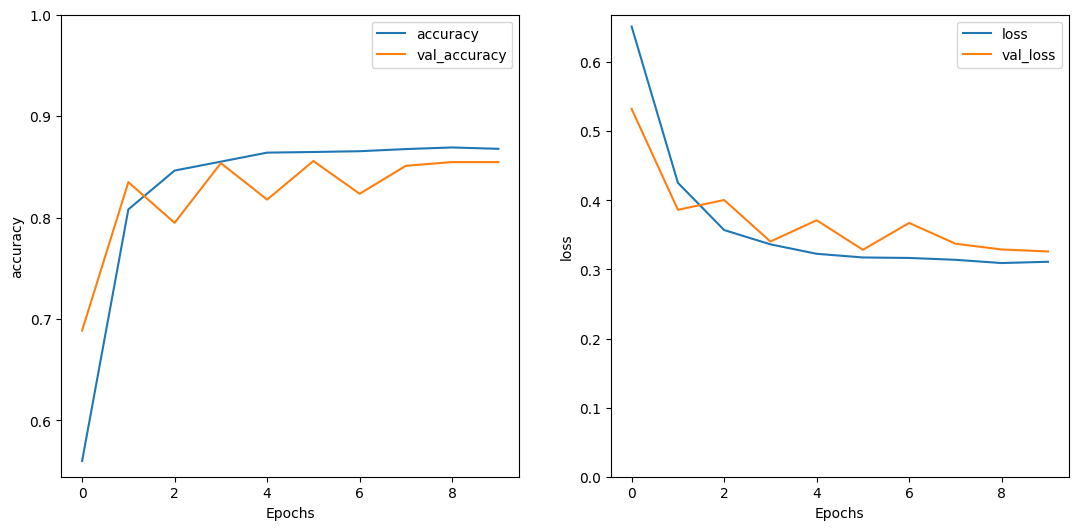

In [16]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Como teste, podemos passar uma sentença qualquer para classificação na nossa rede antes do treinamento

* Como os pesos foram apenas inicializados e não treinados, a rede coloca um valor ligeiramente negativo (sentença negativa em termos de sentimento), mostrando que não há muita "certeza" nessa classficação

In [20]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[0.69022655]]


In [21]:
texts = [
    "The movie was cool.",
    "I did not enjoy the film.",
    "It was amazing!"
]
predictions = model.predict(tf.constant(texts))
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[[0.34749755]
 [0.4905881 ]
 [1.0697856 ]]
